# 🎬 Analyse exploratoire du dataset MovieLens


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import count
import numpy as np
from pyspark.sql.window import Window

# 📋 Config d'affichage
pd.set_option('display.max_columns', None)


In [2]:
ratings_df = pd.read_csv("/root/data/rating.csv")
movies_df = pd.read_csv("/root/data/movie.csv")

## Aperçu des données

In [3]:
print("movies_df.csv : ")
display(movies_df.head())

print("ratings_df.csv :")
display(ratings_df.head())



movies_df.csv : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


ratings_df.csv :


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## Types de données


In [4]:
# 🔍 Dimensions
print("Movies :", movies_df.shape)
print("Ratings :", ratings_df.shape)

# ℹ️ Informations sur les colonnes
print("\nMovies:")
movies_df.info()
print("\nRatings:")
ratings_df.info()


Movies : (27278, 3)
Ratings : (20000263, 4)

Movies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB

Ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


## Nettoyage des doublons avant modélisation

In [5]:
movies_df = movies_df.drop_duplicates(subset=['movieId'])
ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId', 'timestamp'])

## Analyse des valeurs manquantes


In [6]:
print("Movies :\n", movies_df.isnull().sum())
print("\nRatings :\n", ratings_df.isnull().sum())

Movies :
 movieId    0
title      0
genres     0
dtype: int64

Ratings :
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


## Exploration des genres de films


In [7]:
genres_exploded = movies_df['genres'].str.split('|').explode()
genres_uniques = genres_exploded.unique()

print("Genres distincts :", genres_uniques)
print("Nombre de genres :", len(genres_uniques))

Genres distincts : ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']
Nombre de genres : 20


In [9]:
genre_counts = genres_exploded.value_counts().reset_index()
genre_counts.columns = ['genre', 'count']
print("\nTop 5 genres:")
print(genre_counts.head())


Top 5 genres:
      genre  count
0     Drama  13344
1    Comedy   8374
2  Thriller   4178
3   Romance   4127
4    Action   3520


## Visualisation : Nombre de films par genre


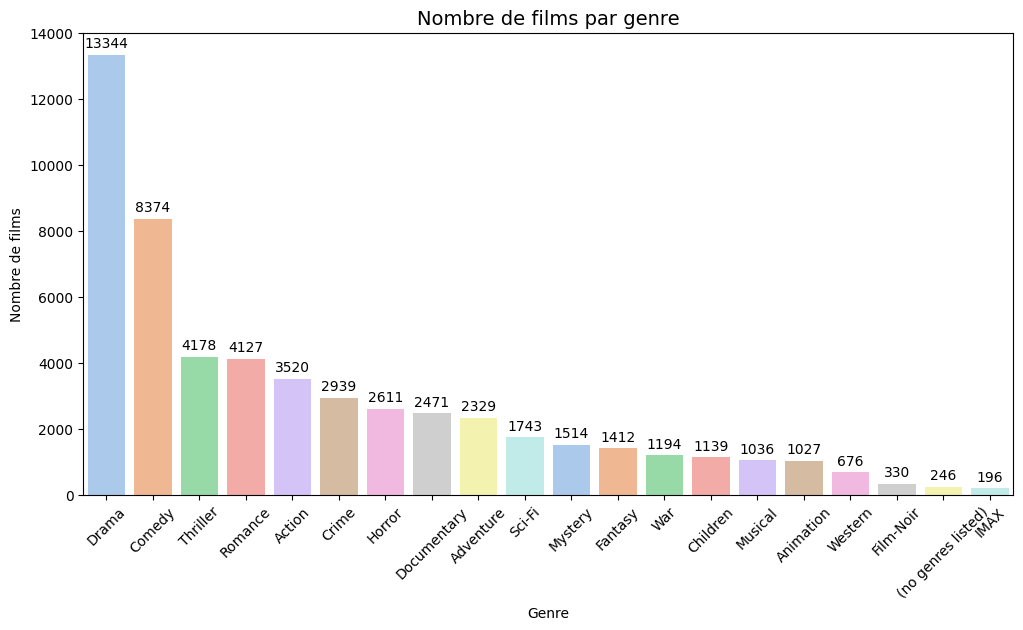

In [12]:
plt.figure(figsize=(12, 6))

ax = sns.barplot(data=genre_counts, x='genre', y='count', hue='genre', palette='pastel', legend=False)

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.title('Nombre de films par genre', fontsize=14)
plt.xlabel('Genre')
plt.ylabel('Nombre de films')
plt.xticks(rotation=45)
plt.show()

## Visualisation 1 : Distribution des notes

Affichons la distribution des notes données par les utilisateurs.  
Les notes vont de 0.5 à 5 par pas de 0.5.


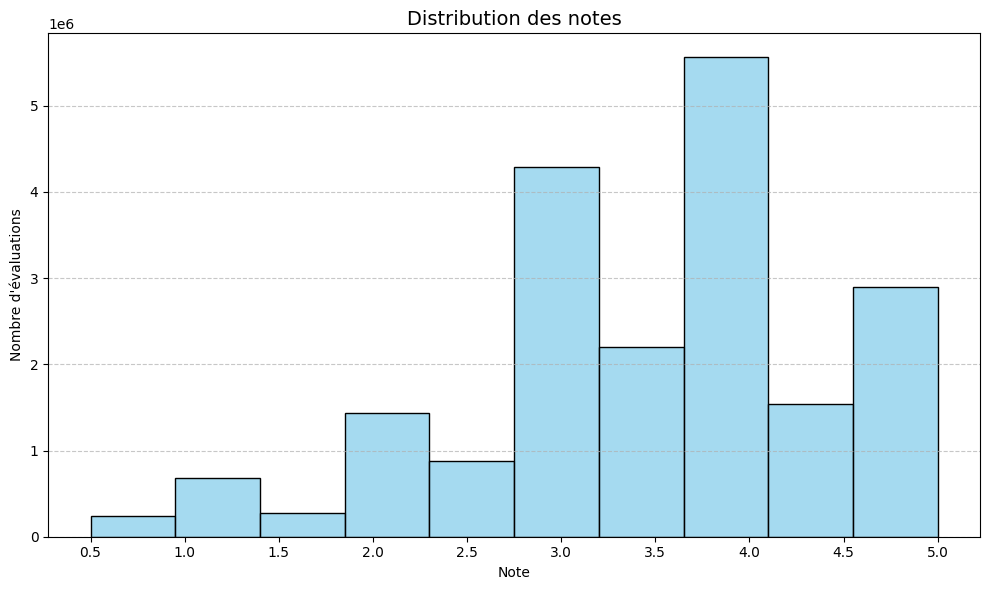

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=False, color='skyblue')

plt.title('Distribution des notes', fontsize=14)
plt.xlabel('Note')
plt.ylabel('Nombre d\'évaluations')
plt.xticks(ticks=np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Visualisation 2 : Nombre de note par ans

In [ ]:
# Conversion du timestamp 
ratings_df['date'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['date'].dt.year

plt.figure(figsize=(10,4))
ratings_df['year'].value_counts().sort_index().plot()
plt.title("Nombre de note par ans")
plt.xlabel("Année")
plt.ylabel("Nombre de notations")
plt.grid(True)
plt.tight_layout()
plt.show()


## Visualisation 3 : Note Moyenne par genre

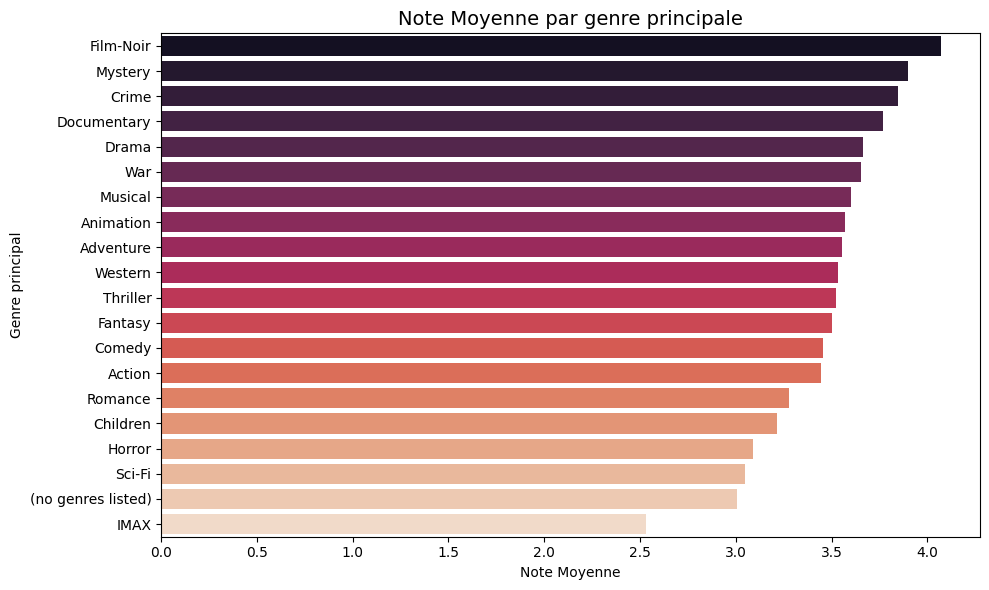

In [16]:
movies_df['main_genre'] = movies_df['genres'].str.split('|').str[0]
ratings_with_genre = ratings_df.merge(movies_df[['movieId', 'main_genre']], on='movieId')

genre_avg = ratings_with_genre.groupby('main_genre')['rating'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=genre_avg, x='rating', y='main_genre', hue='main_genre', palette='rocket', legend=False)  
plt.title("Note Moyenne par genre principale", fontsize=14)
plt.xlabel("Note Moyenne")
plt.ylabel("Genre principal")
plt.tight_layout()
plt.show()

## 🔗 Corrélations exploratoires : année de sortie, note moyenne, nombre de notations

L'année de sortie d'un film n'est pas présente dans une colonne dédiée, mais est incluse dans le titre sous forme de texte, comme `"The Matrix (1999)"`.

Nous allons :
- Extraire cette année de sortie
- Calculer la note moyenne et le nombre de notations par film
- Observer s'il existe des tendances globales entre ces variables

> ⚠️ Cette analyse est exploratoire. Le dataset MovieLens reflète les notations d'une communauté d'utilisateurs sur une période donnée. Les corrélations doivent donc être interprétées avec prudence.


In [18]:
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)').astype(float)

film_stats = ratings_df.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

film_stats = film_stats.merge(movies_df[['movieId', 'year']], on='movieId')
film_stats.dropna(subset=['year'], inplace=True) 
print(film_stats.head())

   movieId  avg_rating  rating_count    year
0        1    3.921240         49695  1995.0
1        2    3.211977         22243  1995.0
2        3    3.151040         12735  1995.0
3        4    2.861393          2756  1995.0
4        5    3.064592         12161  1995.0


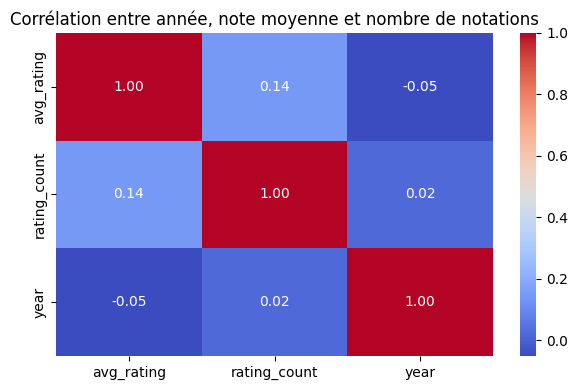

In [20]:
corr_matrix = film_stats[['avg_rating', 'rating_count', 'year']].corr()

# Visualisation - removed emoji from title to avoid font issues
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre année, note moyenne et nombre de notations")
plt.tight_layout()
plt.show()


## 🧠 Interprétation

- La corrélation entre `year` et `rating_count` permet d'observer si les films récents sont plus notés (ce qui est souvent le cas).
- La corrélation entre `year` et `avg_rating` peut indiquer une tendance globale dans l'évaluation des films selon leur époque.
- Une faible ou négative corrélation peut montrer que les films anciens, même peu vus, sont souvent très bien notés (biais de nostalgie ?).

Ces résultats ne doivent pas être considérés comme des vérités absolues mais comme des **indices utiles** pour guider les prochaines analyses (ex. filtrage par années, pondération des notes, etc.).


## 📈 Scatterplot : Note moyenne en fonction de l'année de sortie

Ce graphique permet de visualiser chaque film individuellement :
- Sa note moyenne (`y`)
- Son année de sortie (`x`)
- Le **nombre de notations** (taille du point)

Cela permet de repérer les films très bien notés avec très peu de votes, ou à l'inverse très populaires.


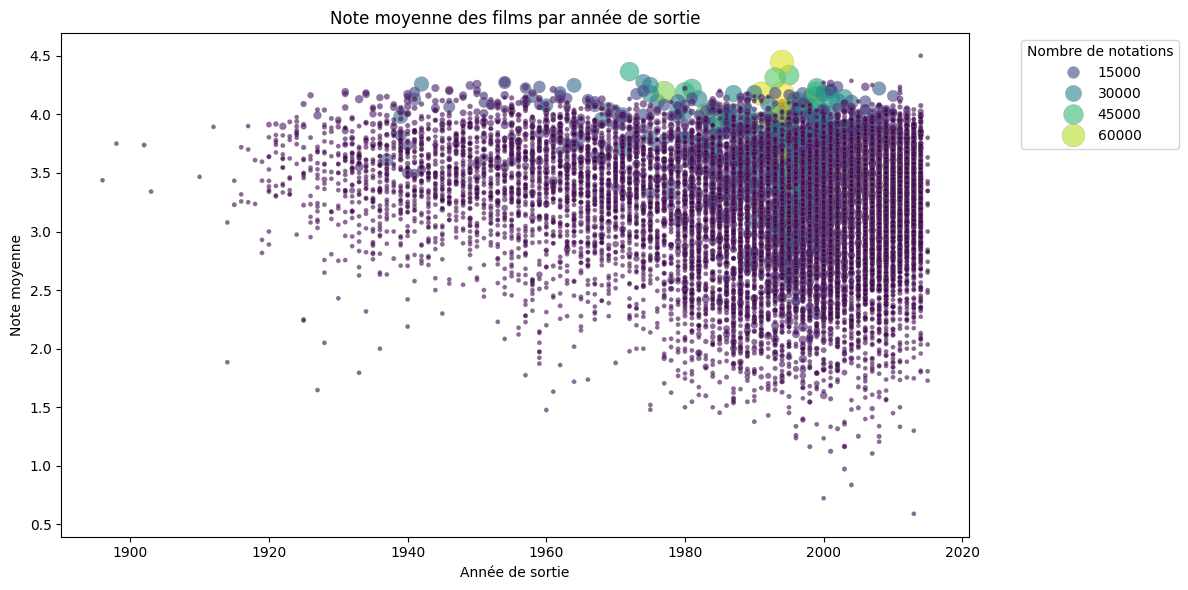

In [22]:
filtered_stats = film_stats[film_stats['rating_count'] >= 10]

plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=filtered_stats,
    x='year', 
    y='avg_rating',
    size='rating_count',
    sizes=(10, 300),         # taille minimale et maximale des points
    alpha=0.6,
    hue='rating_count',
    palette='viridis',
    edgecolor='grey'
)
# Removed emoji from title to fix font warning
plt.title("Note moyenne des films par année de sortie")
plt.xlabel("Année de sortie")
plt.ylabel("Note moyenne")
plt.legend(title="Nombre de notations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 🧠 Conclusion – Analyse visuelle des notes par année

Ce scatterplot met en évidence plusieurs éléments intéressants :

- 📊 Les films récents (après 2000) sont largement plus représentés dans les notations.
- ⭐ Certains films affichent des notes moyennes très élevées, mais n'ont été notés que par un petit nombre d'utilisateurs (points petits et isolés).
- 🎯 Une majorité de films ont des notes concentrées entre **3.0 et 4.0**, indépendamment de leur année de sortie.
- 🧨 Quelques outliers bien visibles mériteraient d'être examinés (films très anciens très bien notés ? ou artefacts de données ?
